# Homework 2: Single Cell Analysis I: Graph algorithms to build a simple cell trajectory inference tool to analyze RNA-seq data.

This homework is worth 75 out of 100 points (your PCA workshop will also be included in the grade, contributing the remaining 25 possible points). The breakdown of points is noted on each numbered question/task.

# Introduction

The goal of this homework is to guide you through the analysis of an unknown single-cell dataset. You will attempt to infer the underlying biological process using a graph-theoretic "trajectory." Single cell data are highly dimensional, with potentially many noisy dimensions. In the previous workshop, we have seen how PCA could be used to reduce the dimensionality of the data and summarize some aspects of it. However, it doesn't inform us on the overall relationships between cells in the data, which is often refered to as the data manifold (low-dimensional topology on which the dataset lies).
For that reason, it is helpful to calculate a low-dimensional approximation to the biologically-relevant manifold. 
$k$-Nearest Neighbors graphs are a technique that can help identify such a lower dimensional representation that you will compute and manipulate in this assignment. <br>

In [1]:
!pip install scanpy
!pip install gseapy

  Using cached https://files.pythonhosted.org/packages/a1/6b/7f62017e3f0b32438dd90bdc1ff0b7b1448b6cb04a1ed84f37b6de95cd7b/h5py-2.10.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b4/4d/8a2c06cb69935bb762738a8b9d5f8ce2a66be5a1410787839b71e146f000/matplotlib-3.2.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/4a/94/66206cb915893196cb4e0db3aba3cc0504d1bb4739b0c2478371664dd8ea/tbb-2019.0-py3-none-win_amd64.whl
  Created wheel for umap-learn: filename=umap_learn-0.4.4-cp37-none-any.whl size=67905 sha256=9921506035886aa008aa5dff80d4e88bd93a7d7344c4163e68e4d07258b440f0
  Stored in directory: C:\Users\Abdulqader\AppData\Local\pip\Cache\wheels\81\d9\a7\91f374756d0966c04104d388ad3b288f332ba706490e8a0fd4
Successfully built umap-learn
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:


ERROR: umap-learn 0.4.4 has requirement numba!=0.47,>=0.46, but you'll have numba 0.45.1 which is incompatible.
ERROR: umap-learn 0.4.4 has requirement numpy>=1.17, but you'll have numpy 1.16.5 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\h5py-2.9.0.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.



In [2]:
# Load packages
# import scanpy as sc
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import sys
import gseapy as gp
import matplotlib.pyplot as plt
import os
import operator
import seaborn as sns

# remove that if not in Colaboratory
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('drive/My Drive/Colab Notebooks/')

Creating directory C:\Users\Abdulqader\AppData\Local\bioservices\bioservices 


#### Working with scanpy Anndata object
The single-cell package we use here, scanpy, uses a specific object format called Anndata (annotated dataset). It provides an efficient data structure for performing computations and keeping metadata. You can read more here :https://anndata.readthedocs.io/en/stable/anndata.AnnData.html#anndata.AnnData <br>

The important attributes to know how to access are:
1. _Anndata.X_ : access the data (sparse matrix). It is indexed cell x gene, and you can slice it.
2. _Anndata.obs_: access observables (metadata as a dataframe) related to cells (cell names are stored as index). You can access existing/create new columns by calling _Anndata.obs['meta']_, where meta is the name of the column.
3. _Anndata.var_: access variables (feature information as a dataframe) related to genes (gene names are stored as index). For example if you want the ordered list of genes: _Anndata.var.index.tolist()_
4. _Anndata.obsm_: access coordinates of dimensionality methods (AxisArray, you can access keys similarly to a dictionary). For example, to access the PCA coordinates, use "Anndata.obsm['X_pca']". It is a cell x n_dimensions array.

In [0]:
# Load dataset
adata = sc.read('sc_dataset.h5ad')

## Part 1: k-NN computation
In this part, you will re-use the PCA algorithm you wrote during the workshop (or use Python $\textit{sklearn}$ package) to reduce dimensionality of the dataset, and implement the $k$-Nearest Neighbors ($k$-NN) graph algorithm. <br>

Consider a single-cell dataset with dimension $n\times m$ ($n$ cells and $m$ features). <br>
A $k$-NN graph is a graph $G$ containing $n$ vertices (one per cell), where each cell is connected with an edge to its $k$ nearest cells. <br>
This implies that we need to define a distance function to get pairwise distances between each cells. <br>
In this homework, we will use Euclidean distance, defined between two cells (vectors) $\mathbf{p}$, $\mathbf{q} \in \mathbb{R}^m$ as: 

\begin{align}
    d(\mathbf{p},\mathbf{q}) = d(\mathbf{q},\mathbf{p}) = \sqrt{(p_1-q_1)^2 + \dots + (p_m-q_m)^2} \nonumber
\end{align}

Complete the following steps by answering questions and filling in the code scaffold appropriately. <br>



1.   (5 pts) Apply PCA to transform the data with $N=30$ principal components (PCs). Add a plot with the embedding for the first 2 PCs, and the Skree plot (amount of variance explained by each PC), similarly to what you have done for the workshop.
2.   (5 pts) Implement the construction of the matrix $\mathbf{D}$ of pairwise distances between cells using Euclidean distance by filling in the code. Verify that your matrix is of size $n\times n$.
3.   (15 pts) Implement the $k$-NN graph algorithm in the provided code. The method should return a $n\times n$ adjacency matrix where the element $(i,j)$ is the distance of the edge between cell $i$ and cell $j$. Run the method using $k=7$ neighbors and $n\_comps=20$ dimensions.
4.   (5 pts) Use the provided code to compute the pairwise shortest path distance matrix (which stores the pairwise shortest path distance between each nodes in the graph) in the $k$-NN graph. <br>Compare it with the pairwise distances you computed on the dataset for making the $k$-NN by making a scatter plot (_hint: You can flatten an array using array.flatten()_). Do you see any relationship between both ? 
**In general the relationship between both distance and shortest path length is a positive relationship where generally as the distance increases the shortest path length will also increase.**


In [3]:
# Add your PCA code here (your own or sklearn)
from sklearn.decomposition import PCA

# apply PCA from sklearn.decomposition
adata_pca = PCA(n_components= 30)
adata_pca.fit(adata.X)
transformed_data = adata_pca.transform(adata.X)

# Plot data transform with 2 first PCs
plt.scatter(transformed_data[:,0], transformed_data[:,1], c='blue')
plt.title('PCA Results')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Plot skree plot

# to clarify, attribute explained_variance_ is the eigenvalues of the cov matrix
x_pos = [i+1 for i in range(len(adata_pca.explained_variance_))]
plt.plot(x_pos[:], adata_pca.explained_variance_[:], linewidth=3, mec= 'b', mfc = 'white')
plt.title('Skree plot')
plt.show()

# Transform the data using 50 PCs and put them into the adata object as:
adata.obsm['X_pca'] = transformed_data

NameError: name 'adata' is not defined

In [0]:
# Implement kNN graph. The method should return a weighted adjacency matrix of the graph.
from sklearn.metrics.pairwise import euclidean_distances

def get_pairwise_dist(X):
    """Build a NxN pairwise euclidean distance matrix."""
    # Fill code here ...
    D = euclidean_distances(X, X)
    assert D.shape[0] == D.shape[1]
    return D

def knn_graph(adata, n_neighbors, use_pca=True, n_comps=20):
    """Build kNN graph based on input Anndata object and using euclidean distance as metric.
    Hint: Don't forget to remove self-distances since in adjacency matrix diagonal is 0.
    Note: 0 means not connected and is treated as infinite distance."""
    if use_pca:
        data = adata.obsm['X_pca'][:,:n_comps]
    else:
        data = adata.X
    # Build kNN
    # Fill code here ...
    D = get_pairwise_dist(data[:][:])
    adj_mat = np.zeros(D.shape)
    
    for col in range(len(D)):
        # this is to augment the n closest neighbors
        # since we cannot have a length of 0
        start_pos = 0

        # sort postions based on values in D
        positions = [i for i in range(len(D))]
        sorted_col = sorted(positions, key= lambda x: D[col][x])[1:]

        # find how many values in the column are 0 and skip those
        while D[col][sorted_col[start_pos]] == 0.0: start_pos +=1
        n_closest = sorted_col[start_pos: n_neighbors + start_pos]

        # assign 1 to values in adj_mat
        for i in n_closest: adj_mat[col][i] = D[col][i]

    return adj_mat

def construct_nx_graph(adj_mat):
    """Simply call nx.from_numpy_array"""
    return nx.from_numpy_array(adj_mat, parallel_edges= False)

In [0]:
# Build knn adjacency matrix
knn_adj = knn_graph(adata, n_neighbors=7, use_pca = True, n_comps=20)
# Load in networkx graph object
knn_g = construct_nx_graph(knn_adj)

Text(0, 0.5, 'Shortest Path Length')

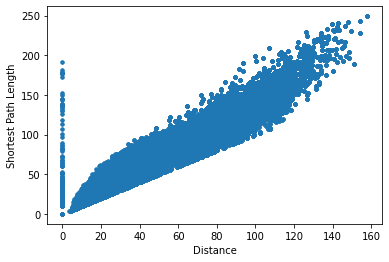

In [7]:
# Get Pairwise distance matrix and Pairwise shortest path length matrix
dist_mat = get_pairwise_dist(adata.obsm['X_pca'][:,:20])
dict_length = nx.all_pairs_dijkstra_path_length(knn_g)
path_mat = np.zeros((len(adata),len(adata)))
for tup_k in dict_length:
    for k2 in tup_k[1].keys():
        path_mat[tup_k[0], k2] = tup_k[1][k2]
# Plot scatter of distances vs shortest path length and observe correlation
plt.scatter(dist_mat.flatten(), path_mat.flatten(), s=10)
plt.xlabel('Distance')
plt.ylabel('Shortest Path Length')

## Part 2: Minimum Spanning Tree in the $k$-NN graph

In this part, we will work with the python package $\texttt{networkx}$. You will need to load your adjacency matrix into a graph object using $\texttt{networkx.convert_matrix.from_numpy_array}$. <br> 
We will try to find the Minimum Spanning Tree (MST) in the graph. We will assume that important cell transitions lie along the main path of this tree (identified in a subsequent step).  The MST corresponds to a subset of edges in the $k$-NN graph where all the nodes are connected together without any cycle, and with the minimum total weight possible. You will implement the Kruskal algorithm, the classic approach to finding the MST. The pseudocode is the following: <br>


*   _Sort edges in the graph by increasing weight_
*   _Start from the smallest edge to grow the tree. For each edge, check if it forms a cycle with the tree, and if it does discard it. If it doesn't, add it to the tree._
*   _Repeat until there are N-1 edges in the tree, with N the number of nodes of the $k$-NN graph._

(_Hint: For the second step, look into the Union-find algorithm to detect cycles_)

<br>



5. (15 pts) Fill the code scaffold appropriatly. Implement the Kruskal algorithm, taking your $k$-NN graph as an input. Run on it on your $k$-NN and verify that you have $n-1$ edges, where $n$ is the number of nodes in the $k$-NN/cells in the dataset. <br>





In [0]:

def mst_kruskal(g):
    """Implement Kruskal algorithm for MST using Nx object.
    The method should return a list of edges and their weight as a tuple with 3 elements:
    (node_i, node_j, weight_ij)
    
    You can create helper functions to solve this problem. But don't 
    use networkX MST algorithm!."""
    # Initialize empty MST list
    mst = []
    # Fill code here...

    list_of_sets = []
    list_of_edges = []

    # create a list of sets, following the union find method
    for node in g:
        list_of_sets.append({node})

    # collect a list of edges. 
    for edge in g.edges(data=True):
        weight = edge[2]['weight']
        list_of_edges.append((edge[0], edge[1], weight))

    # sort the edges by increasing weight
    list_of_edges = sorted(list_of_edges, key= lambda x: x[2])

    # Apply the union find algorithm find 
    # the set each node i and j is in.
    # If the sets are different, union both sets and 
    # add the edge to mst. 
    for node_i, node_j, weight in list_of_edges:
        set_of_i = find_set(node_i, list_of_sets)
        set_of_j = find_set(node_j, list_of_sets)
        if set_of_i != set_of_j:
            mst.append((node_i, node_j, weight))
            list_of_sets[set_of_i] = list_of_sets[set_of_i].union(list_of_sets[set_of_j])
            del list_of_sets[set_of_j]

        if len(mst) == len(g) - 1: break
   
    return mst

def find_set(node, list_of_sets):
    ''' Helper function for mst_kruskal. '''
    for set_obj in range(len(list_of_sets)):
        if node in list_of_sets[set_obj]: return set_obj
    return -1


In [9]:
mst = mst_kruskal(knn_g)
# Verify you have n-1 edges
len(mst) == adata.shape[0] -1 

True

## Part 3: Pseudotime estimation

In this part, you will use the structure of the MST to find a "trajectory" (continuum of cells) that may represent some biological progression (you will be asked to guess at what this is at the end of the homework). You will then estimate the pseudotime of each cell along this continuum. Pseudotime can be seen as a computationaly-derived estimation of how far a cell is on a path that connect the start and the end of a trajectory. <br> 

We will call _backbone_ the path that connects the root $R$ (start of the trajectory) to the tip $T$ (end of the trajectory). We want to project each cell $x$ on the backbone of the MST to measure how far it is from $R$ (_ie_ how far it is on the trajectory). The projection of $x$ can be derived from the length of the path connecting $R$ to $x$ and the one from $x$ to $T$. See the diagram below that illustrates this relationship:

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vRmwLffz3OI2hqTTXX-qfc2IioNAphdzniuw5FJanPaiFd8XBHQR1kNCdnmAJSQqqWNCRQ_9Ov-v7RU/pub?w=291&h=209)

The blue paths illustrate distances you have available from the shortest path algorithm. We would like to calculate the pseudotime, which is the fraction $\frac{d(R,x')}{d(R,T)}$, where x' denotes the projection of x on the path from R to T. Note that you do not have d(R,x') (the red path in the diagram) and need to calculate it from the other path distances.

Answer the following questions and fill the code scaffold appropriately.

6.   (10 pts) Derive the mathematical expression of the pseudotime of cell $x$ given the backbone length $d(R,T)$. _Hint: Use $d(R,x)$ and $d(x,T)$_

**Given that the pseudotime of $x$ is $\frac{d(R, x')}{d(R, T)}$ we must first find $d(R, x')$. The distance can be calculated using the intution below:**
1. **If $d(R, x) = d(x, T)$, it means that $x'$ is the midpoint of $d(R, T)$.**
2. **If $d(R, x) > d(x, T)$, it means that $x'$ is further from $R$ than it is from $T$ and vice versa can be assumed if $d(R, x) < d(x, T)$.**
**Therefore:**

$$ d(R, x') = \frac{d(R, T) + d(R, x) - d(x, T)}{2}$$
**And if we want the Psuedotime of $x$, we just adjust it as below:**

$$ Psuedo(x | R, T) = \frac{d(R, T) + d(R, x) - d(x, T)}{2 \times d(R,T)}$$

2.   (5 pts) Fill in the method to compute the pseudotime for each cell given a list of roots and tips. The method should iterate over each ordered pair (root,tip) and return a mean pseudotime estimated from the pseudotime derived from each pair.
3.   (5 pts) Use the provided code to plot the cells colored by pseudotime and sample ID. What do you think the sampling strategy was ? 
**It seems the sampling stragety was dependent on the pseudotime of the given node given the clusters seen on the pseudotime graph and generally each cluster color matches the cluster colors of sample.**
4.   (5 pts) Make a boxplot showing the distribution of pseudotime for each sample; i.e. sample1 will have a box-and-whisker, sample2 will have its own, etc showing the psuedotimes on the y-axis for each of these groups. Does this plot support your answer in the previous question ?
**The seaborn boxplot matches the intution, the each sample has a distinct average for pseudotime and sample 1 has a much lower pseudotime then sample 5 group.**

In [0]:
# Prepare the MST for pseudotime part: Load into graph and set attributes
mst_graph = nx.Graph()
mst_graph.add_nodes_from(range(len(knn_g)))
mst_graph.add_weighted_edges_from(mst)

samples = adata.obs['sample'].tolist()
dict_samples = {i:samples[i] for i in range(len(samples))}

nx.set_node_attributes(mst_graph, dict_samples, name='attribute')

In [0]:
# Fill in this code
def pseudotime_estimate(G, root_list, target_list):
    """Method for estimating the pseudotime of each cell.
    The method should work by taking the MST networkx graph as input, as well as a
    list of root and tip IDs. Iterate through each pair of (root, tip) and compute
    the pseudotime of each cell by projecting each cell onto the backbone (path 
    between root and tip) of the trajectory. Return the mean pseudotime of each 
    cell over the pairs of root/tips.
    """
    assert len(root_list)==len(target_list)
    n_rep = len(root_list)
    pdt_mat = np.zeros((n_rep,len(G)))
    # Fill code here ...

    for col, (root, target) in enumerate(zip(root_list, target_list)):
        d_RT = nx.dijkstra_path_length(G, source=root, target=target)
        d_RX = [nx.dijkstra_path_length(G, source=root, target=i) for i in range(len(G))]
        d_XT = [nx.dijkstra_path_length(G, source=i, target=target) for i in range(len(G))]

        for j in range(len(G)):
            pdt_mat[col][j] = (d_RT + d_RX[j] - d_XT[j])/ (2 * d_RT)


    return np.mean(pdt_mat, axis=0)

In [0]:
# RUn this to apply your method. We give you the roots and tips to use.
pdt_cells = pseudotime_estimate(mst_graph, root_list=[97,5,1, 66, 88, 55, 13], target_list=[785,824,803, 777, 756, 801, 743])

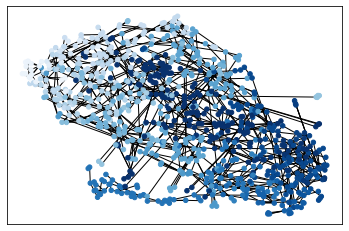

In [13]:
# Extract UMAP plot positions from dataset
pos = adata.obsm['X_umap']
# Plot networkx graph
nx.draw_networkx(mst_graph, node_size=20, node_color=pdt_cells, pos=pos, with_labels=False, cmap=plt.cm.Blues)

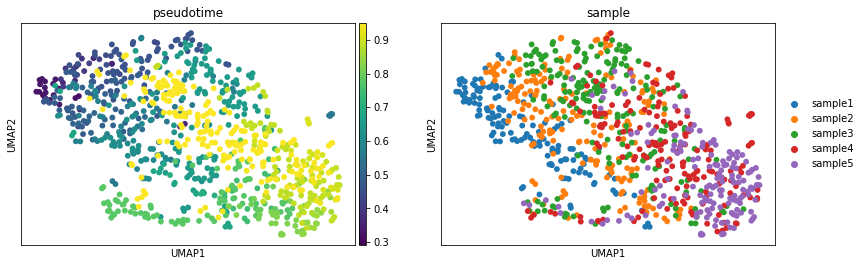

In [14]:
# Add pseudotime to metadata of the dataset and plot with samples
adata.obs['pseudotime'] = pdt_cells
sc.pl.umap(adata, color=['pseudotime', 'sample'])

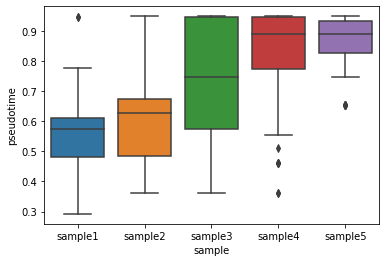

In [15]:
# make the box plot for the data, I chose to use seaborn (sns >> plt, sorry not sorry)
ax = sns.boxplot(x= 'sample', y='pseudotime', data=adata.obs)

#### Part 4: Pseudotime-associated pathways

In this part, we will try to understand the underlying biology of the dataset associated with our estimated pseudotime. Pathway enrichment may help to understand the under biology of the dataset by looking at set of genes significantly enriched in a list of ranked genes. <br>

We give you the code for the following steps: <br>
For each gene in the dataset, perform a simple _t-test_ between the cells whose pseudotime is below 0.5 and the cells whose pseudotime is above 0.5. For each gene, if the $p-value$ of the test is $ < 0.05$, save the absolute value of the test statistic in a separate list. Then sort the gene names and values such that higher test statistic values are higher in the ranking. <br>

Put the results in a dataframe where the first column is the gene names and the second the test values. Run Gene Set Enrichment Analysis with the code provided below. <br>

In [0]:
from scipy.stats import ttest_ind
batch_1 = adata.obs['pseudotime'] < 0.5
batch_2 = adata.obs['pseudotime'] > 0.5
gene_name = []
stat_val = []
for i in range(adata.shape[1]):
    test = ttest_ind(adata.X[batch_1, i], adata.X[batch_2, i])
    if test[1] < 0.05:
        gene_name.append(adata.var.index.tolist()[i])
        stat_val.append(test[0])
    
sorted_genes = np.array(gene_name)[np.argsort(stat_val)[::-1]]
sorted_genes = [i.upper() for i in sorted_genes]
stat_val=np.abs(stat_val)
sorted_val = np.array(stat_val)[np.argsort(stat_val)[::-1]]
data = pd.DataFrame({'gene': sorted_genes, 'tstat': sorted_val})
result = gp.prerank(rnk=data, gene_sets='GO_Biological_Process_2018', processes=10,
                    permutation_num=500, min_size=5, max_size=1000, outdir=None)

In [17]:
# Get number of pathways with FDR < 0.5
print('Number of pathways with FDR < 0.5:', len(result.res2d[result.res2d['fdr'] < 0.5]))
# Print top 10 sorted by NES
print(result.res2d.sort_values('nes', ascending=False).head(10))

Number of pathways with FDR < 0.5: 378
                                                          es  ...                                     ledge_genes
Term                                                          ...                                                
positive regulation of cartilage development (G...  0.815539  ...                   SOX6;SOX5;BMPR1B;ZBTB16;BMPR2
regulation of cartilage development (GO:0061035)    0.852062  ...             SOX6;SOX5;BMPR1B;ZBTB16;BMPR2;TRPS1
positive regulation of chondrocyte differentiat...  0.834643  ...                         SOX6;SOX5;BMPR1B;ZBTB16
bone morphogenesis (GO:0060349)                     0.867724  ...                    BMPR1B;RARB;FGFR2;BMPR2;RARG
positive regulation of osteoblast differentiati...  0.688508  ...  BMPR1A;CYR61;IGF1;BMPR1B;DDR2;FBN2;PRKD1;BMPR2
regulation of chondrocyte differentiation (GO:0...  0.736848  ...            SOX6;SOX5;BMPR1B;ZBTB16;TGFBR1;TRPS1
proteoglycan biosynthetic process (GO:0030166)   

10. (5pts) Observe the top 10 pathways sorted by normalized enrichment score ('nes'). If you had to guess what type of cells were sequenced, and what is happening to the cells, what would you say ? (Hint: Ignore uninformative pathway sets reflecting metabolism or housekeeping like functions; these kinds of pathways often show up in these analyses for spurious reasons).
**I believe leukocyte cells were sequenced and that the cells are expereincing negative regulation of MAP kinases.  I am not sure why there is a negative regulation of MAP kinases, as I do not know where the single cell data is from.**

Turn in this notebook file on the [Canvas HW2 Website](https://canvas.ucsc.edu/courses/32869/assignments/128483).